In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os

## path to repository
os.chdir('/hpcnfs/scratch/DIMA/piva/mpi_freiburg/scmultiome/')

In [2]:
sc.settings.verbosity = 0

# reference

To study the temporal dynamic of the data, a sci-RNA-seq and sci-ATAC-seq dataset composed of WT embryos collected at different time points throughout Drosophila embryogenesis was used as reference to project our scMultiome dataset (Calderon, D. et al. The continuum of Drosophila embryonic development at single-cell resolution. Science (1979) 377, eabn5800 (2022).).

The sci-RNA-seq Seurat object was downloaded from the dedicated public repository hosted on the authors website (https://shendure-web.gs.washington.edu/content/members/DEAP_website/public/).


we selected six time points to capture embryonic stages from before ZGA to gastrulation:
- with 0-2 and 1-3 hours classified as **early stages**, 
- 2-4 and 3-7 hours as **middle stages**,
- 4-6 and 8-10 hours as **late stages**.

In [5]:

adata_ref=sc.read_h5ad('./data/ref/main.h5ad')

In [8]:

stg_00_12=['hrs_00_02','hrs_01_03','hrs_02_04','hrs_03_07','hrs_04_08', 'hrs_06_10']
adata_ref=adata_ref[adata_ref.obs['time'].isin(stg_00_12)]

In [15]:
adata_ref.obs['time'].value_counts()

hrs_00_02    78890
hrs_03_07    62789
hrs_01_03    56028
hrs_06_10    42942
hrs_04_08    41484
hrs_02_04    18951
Name: time, dtype: int64

In [14]:
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)

/hpcnfs/home/ieo6625/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:269: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(


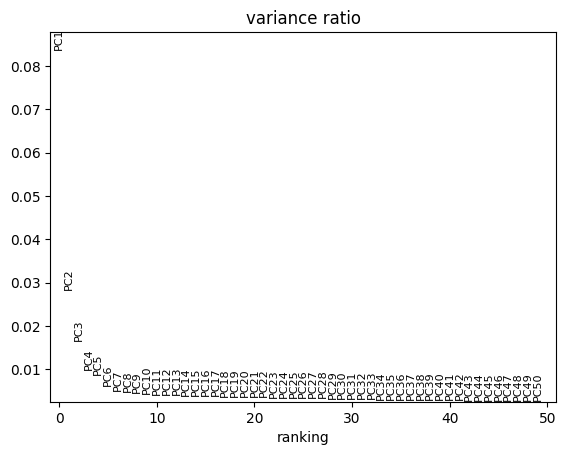

In [55]:
sc.pp.highly_variable_genes(adata_ref, n_top_genes=2000)
sc.pp.pca(adata_ref)
sc.pl.pca_variance_ratio(adata_ref, n_pcs=50)

In [9]:
sc.pp.neighbors(adata_ref,use_rep='X_pca', n_neighbors=15)

/hpcnfs/home/ieo6625/.conda/envs/myenv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpcnfs/home/ieo6625/.conda/envs/myenv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpcnfs/home/ieo6625/.conda/envs/myenv/lib/python3.9/site-packag

In [20]:
sc.tl.umap(adata_ref, n_components=2)

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


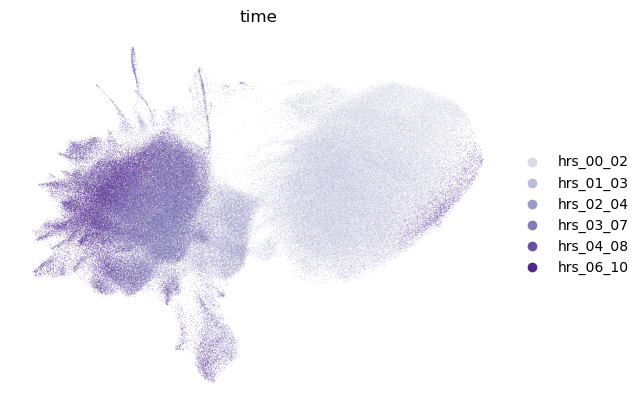

In [13]:
sc.pl.umap(adata_ref, color=['time'], palette=sns.color_palette('Purples', 7)[1:], frameon=False)

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


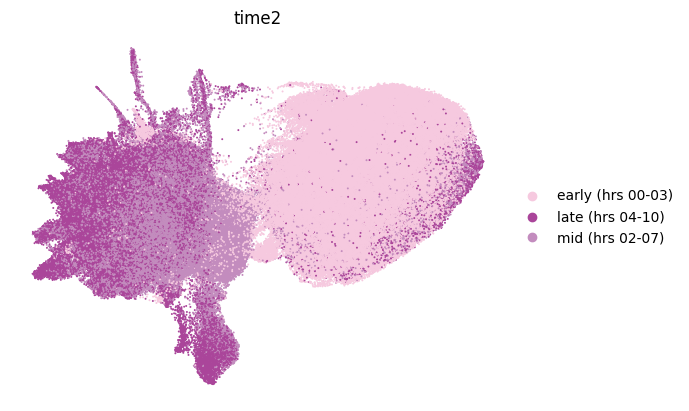

In [4]:
adata_ref.obs['time2']=adata_ref.obs['time'].map({ 'hrs_00_02':'early (hrs 00-03)', 'hrs_01_03':'early (hrs 00-03)',
                                                   'hrs_02_04':'mid (hrs 02-07)', 'hrs_03_07':'mid (hrs 02-07)',
                                                   'hrs_04_08':'late (hrs 04-10)', 'hrs_06_10':'late (hrs 04-10)'} )

sc.pl.umap(adata_ref, color='time2', palette=['#f6c9df', '#aa459a', '#c38cbe'], size=8, frameon=False)

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


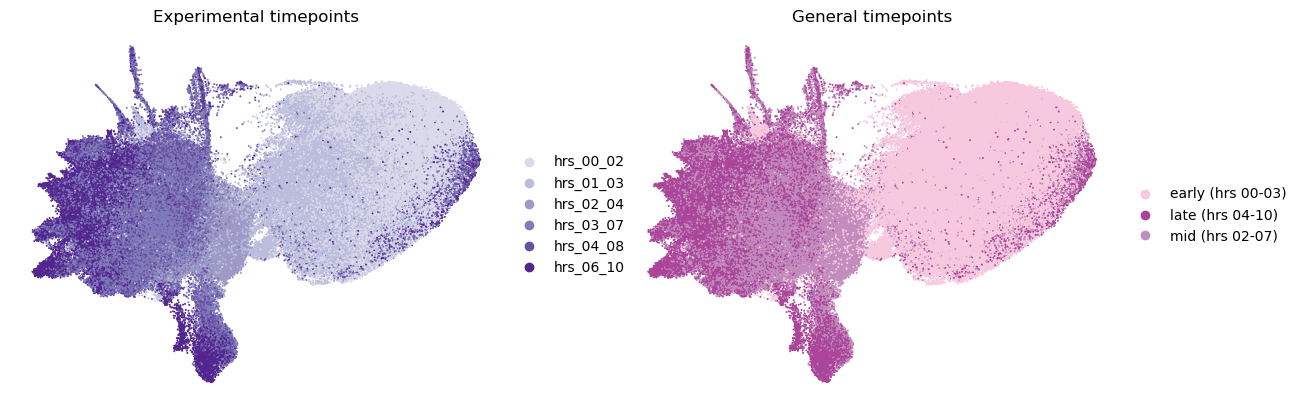

In [15]:
sc.pl.umap(adata_ref, color=['time', 'time2'], size=8, frameon=False, 
           title=['Experimental timepoints', 'General timepoints'] )

# Gene ID conversion

In [26]:
# conversion by flybase database

genes_conv=pd.read_csv('./data/main_genesymbol.csv', sep='\t', index_col=[0])
genes_conv.head()

validated_id  current_symbol
#submitted_item                             
gfzf             FBgn0250732            gfzf
FBti0060344      FBti0060344     INE-1{}2283
sisRNA:CR46358   FBgn0286036  sisRNA:CR46358
Osi24            FBgn0037409           Osi24
msps             FBgn0027948            msps

In [27]:
genes_conv=genes_conv.drop('current_symbol', 1).to_dict()['validated_id']

/var/tmp/pbs.1582498.hpcfe01/ipykernel_14127/407025192.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  genes_conv=genes_conv.drop('current_symbol', 1).to_dict()['validated_id']


In [28]:
adata_ref.var['FBid']=adata_ref.var.index.map(genes_conv)
adata_ref.var

FBid
gfzf             FBgn0250732
FBti0060344      FBti0060344
sisRNA:CR46358   FBgn0286036
Osi24            FBgn0037409
msps             FBgn0027948
...                      ...
CR45933          FBgn0267595
Su(Ste):CR42433  FBgn0259864
CG40635          FBgn0085506
Su(Ste):CR42439  FBgn0259870
lncRNA:CR40719   FBgn0085511

[23932 rows x 1 columns]

In [29]:
adata_ref.var_names=adata_ref.var['FBid']

In [30]:
adata_ref.var_names.nunique()

22984

In [31]:
adata_ref.var_names_make_unique()

# import data

In [32]:
adata_path='./data/adata_RNAassay_normalized.h5ad'
adata=sc.read_h5ad(adata_path)

# ingest

In [34]:
var_names = adata_ref.var_names.intersection(adata.var_names)

adata_ref=adata_ref[:, var_names]
adata=adata[:, var_names]

## ingest (time)

In [ ]:
sc.tl.ingest(adata,        # new data (our scmultiome dataset)
             adata_ref,    # reference data
             embedding_method=('pca','umap'), # only pca and umap are supported
             obs='time')

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'time'}, xlabel='UMAP1', ylabel='UMAP2'>

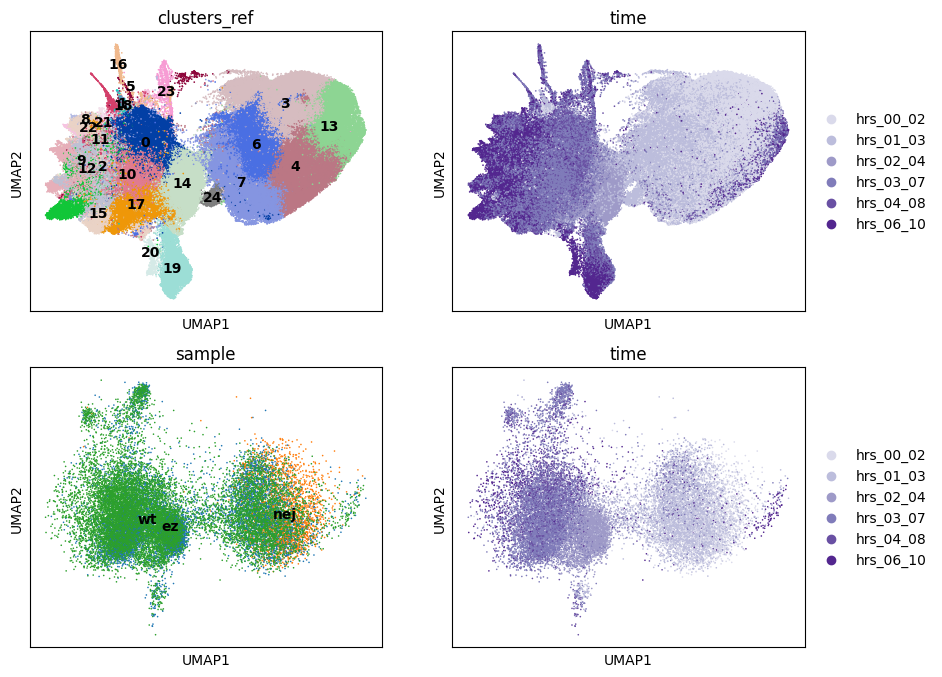

In [6]:
fig, axs=plt.subplots(2,2,figsize=(10,8))
axs=axs.ravel()
sc.pl.umap(adata_ref,color=['clusters_ref'],legend_loc='on data', size=6 ,show=False,ax=axs[0])
sc.pl.umap(adata_ref,color=[ 'time'], size=6 ,show=False,ax=axs[1], palette=sns.color_palette('Purples', 7)[1:],)
sc.pl.umap(adata,color=['sample'], legend_loc='on data',show=False,ax=axs[2])
sc.pl.umap(adata,color=[ 'time' ],show=False ,ax=axs[3], palette=sns.color_palette('Purples', 7)[1:],)

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/

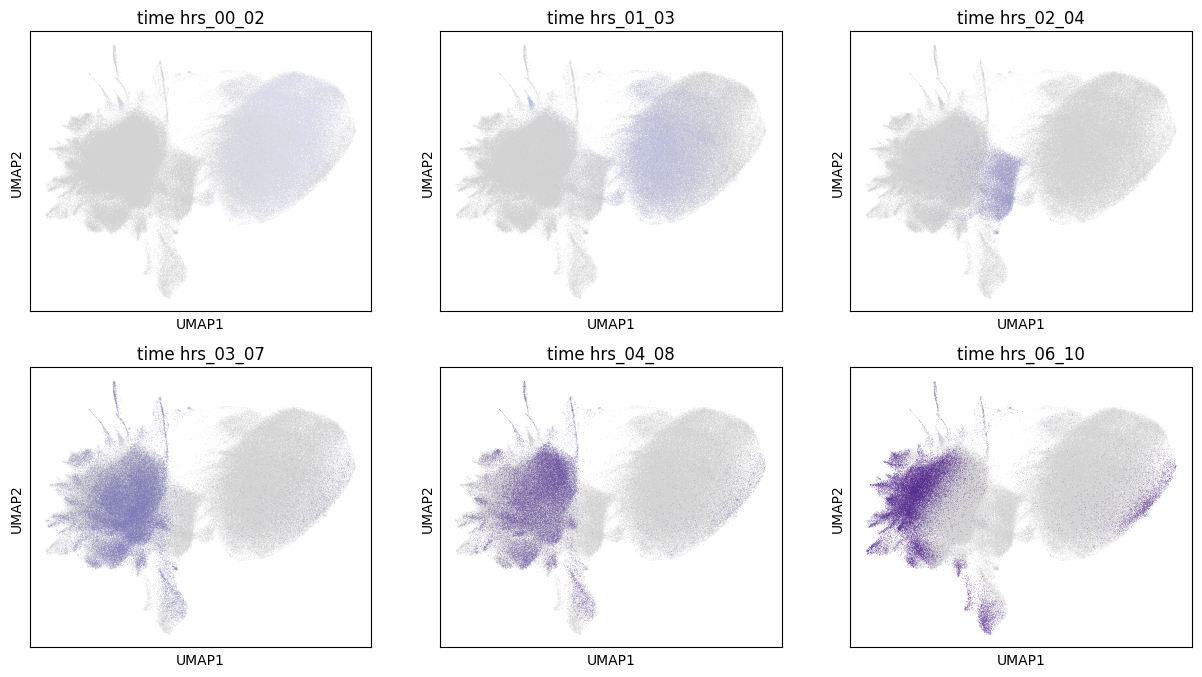

In [7]:
fig, axs=plt.subplots(2,3,figsize=(15,8), )
axs=axs.ravel()
observ='time'
for i,s in enumerate(sorted(adata_ref.obs[observ].unique())):
    sc.pl.umap(adata_ref, color=observ, groups=[s],legend_loc='top right',show=False,ax=axs[i], title='time %s'%(s))
#fig.savefig('figures/ref_time.pdf', dpi=50)

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/

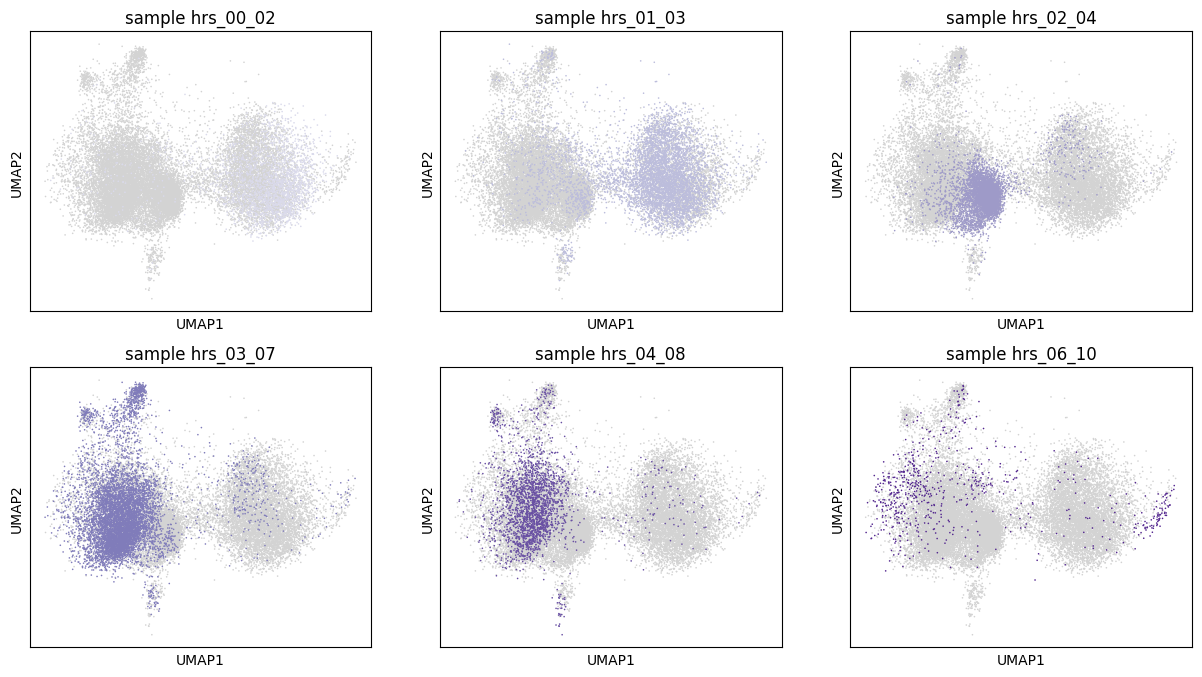

In [8]:
fig, axs=plt.subplots(2,3,figsize=(15,8))
axs=axs.ravel()
observ='time'
for i,s in enumerate(sorted(adata.obs[observ].unique())):
    sc.pl.umap(adata, color=observ, groups=[s],legend_loc='top right',show=False,ax=axs[i], title='sample %s'%(s))

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


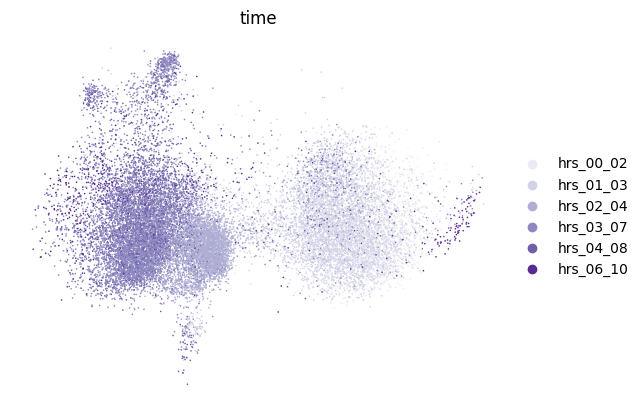

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


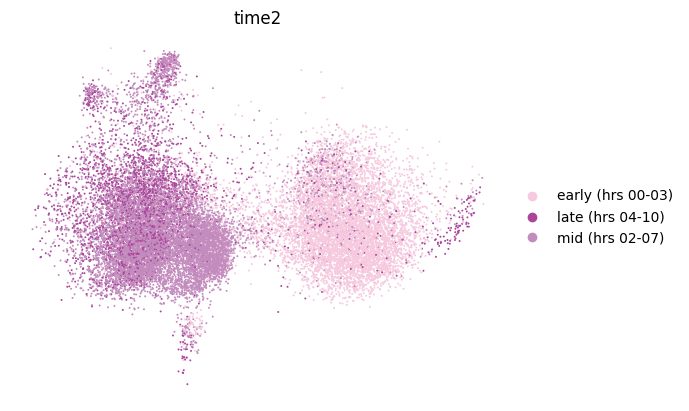

In [12]:
sc.pl.umap(adata, color=['time'], palette=sns.color_palette('Purples', 13)[1::2], frameon=False)
adata.obs['time2']=adata.obs['time'].map({ 'hrs_00_02':'early (hrs 00-03)', 'hrs_01_03':'early (hrs 00-03)',
                                                   'hrs_02_04':'mid (hrs 02-07)', 'hrs_03_07':'mid (hrs 02-07)',
                                                   'hrs_04_08':'late (hrs 04-10)', 'hrs_06_10':'late (hrs 04-10)'} )

sc.pl.umap(adata, color='time2', palette=['#f6c9df', '#aa459a', '#c38cbe'], size=8, frameon=False)

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


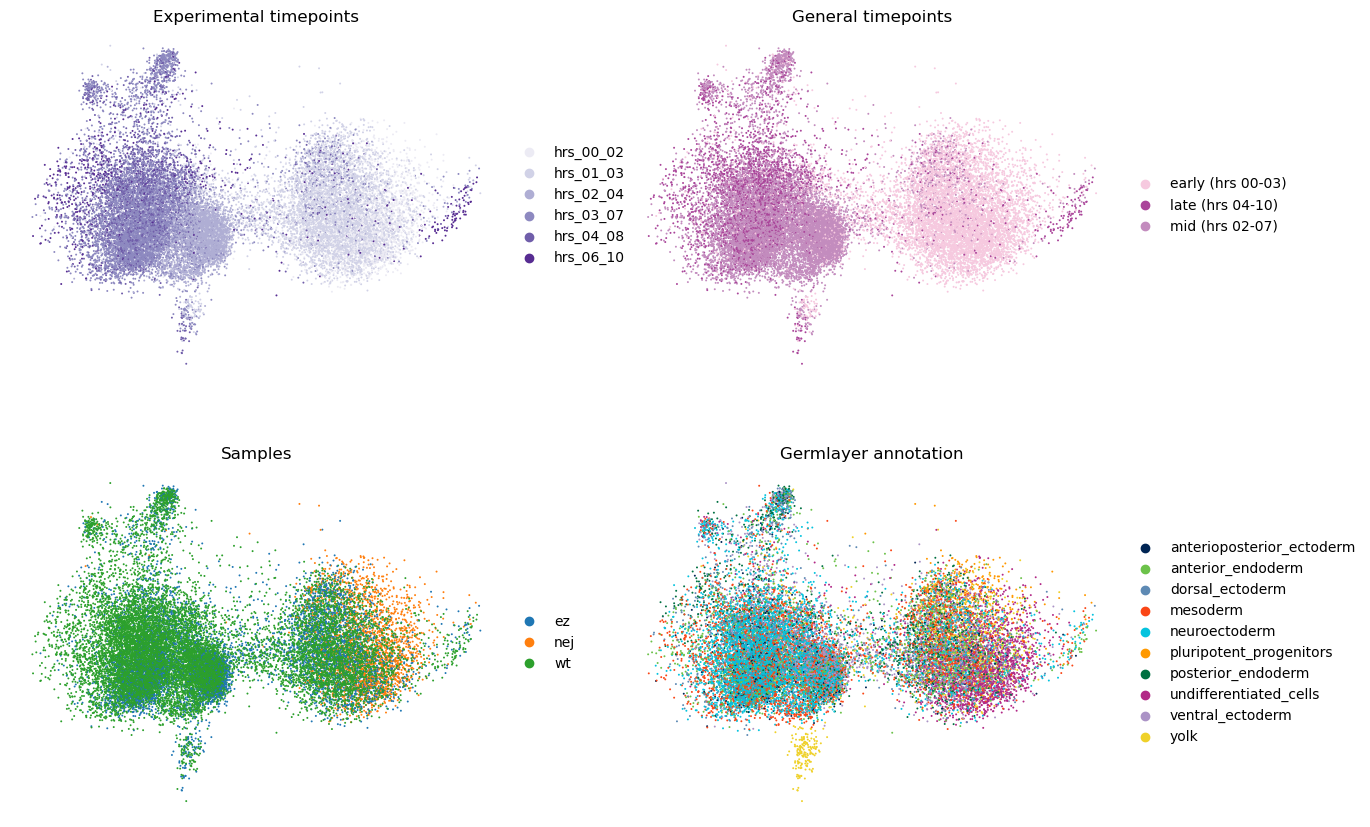

In [35]:
sc.pl.umap(adata, color=['time','time2', 'sample', 'annotation_leiden12'], size=8,frameon=False, ncols=2,
           title=['Experimental timepoints', 'General timepoints', 'Samples', 'Germlayer annotation'] )

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/myenvclone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


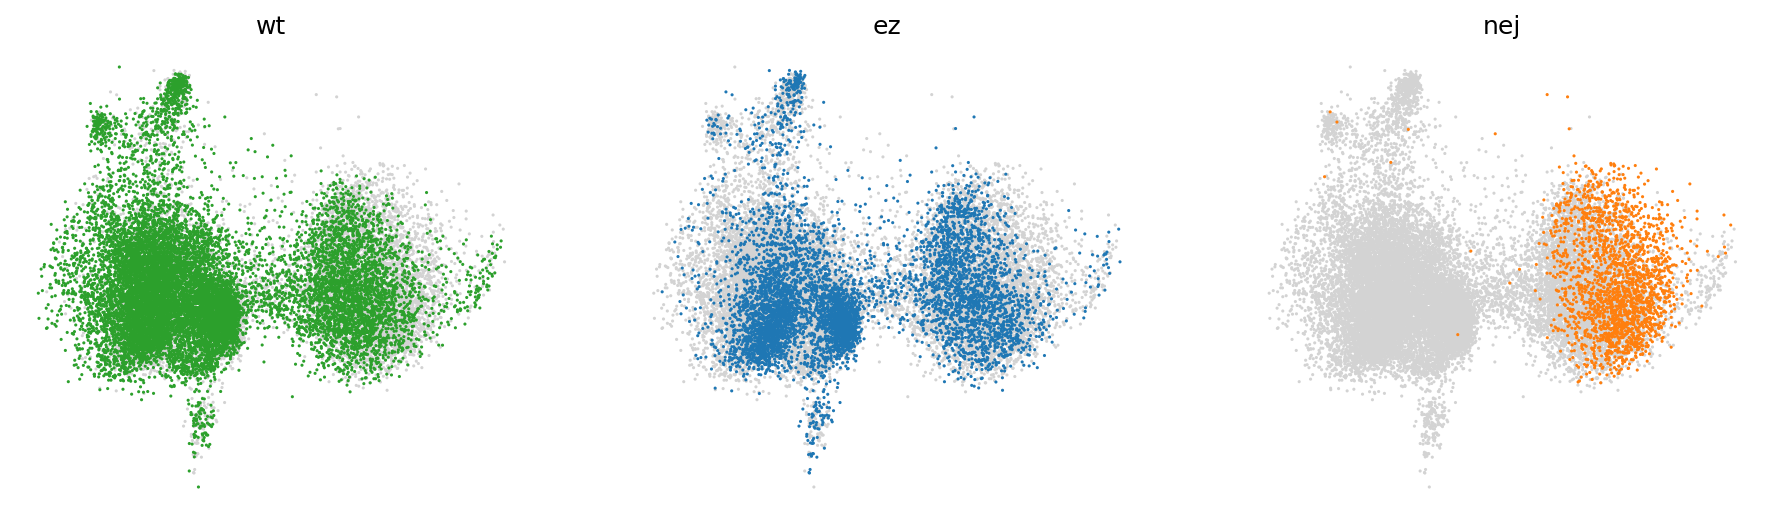

In [37]:
fig, axs=plt.subplots(1,3,figsize=(15,4), dpi=150)
axs=axs.ravel()
for i,s in enumerate(['wt', 'ez', 'nej']):
    sc.pl.umap(adata, color='sample', groups=[s],legend_loc='top right',show=False,ax=axs[i], title='%s'%(s), frameon=False, size=9)
#fig.savefig('figures/data_sample.pdf')

In [13]:
colori_germs= {"anterioposterior_ectoderm": '#002554',
                "mesoderm":'#FA4616',
                "dorsal_ectoderm" :'#5E8AB4',
                "ventral_ectoderm": '#ab93c6',
                "anterior_endoderm":'#6CC24A',
                "posterior_endoderm": '#007041',
                "yolk" : '#efd129',
                "undifferentiated_cells" : '#b22987',
                "pluripotent_progenitors" :'#ff9900',
                "neuroectoderm":"#05C3DE"}

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


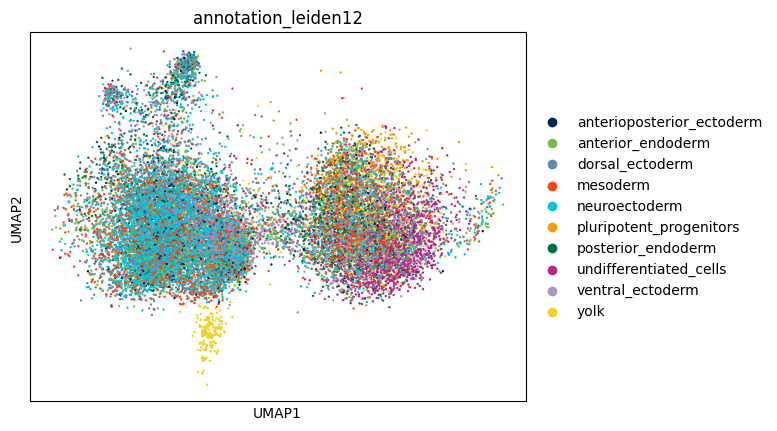

In [14]:
#sc.set_figure_params( figsize=(6, 5), fontsize=13)
observ='annotation_leiden12'
sc.pl.umap(adata, color=observ, palette=colori_germs, size=12)

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/

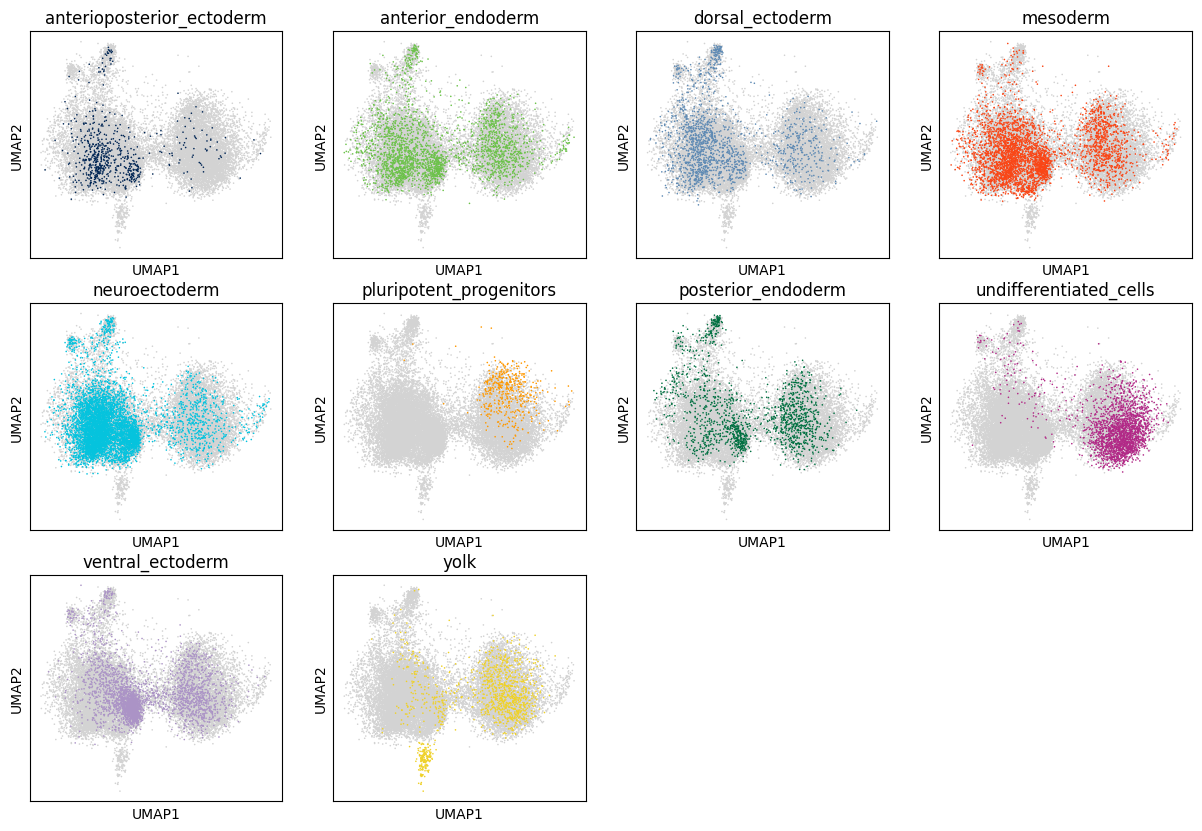

In [15]:
fig, axs=plt.subplots(3,4,figsize=(15,10))
axs=axs.ravel()
observ='annotation_leiden12'
for i,s in enumerate(sorted(adata.obs[observ].unique())):
    sc.pl.umap(adata, color=observ, groups=[s],legend_loc='top right',show=False,ax=axs[i], title='%s'%(s))
axs[10].remove()
axs[11].remove()

#plt.savefig('/hpcnfs/scratch/DIMA/piva/mpi_freiburg/figures/umap_rna_projection_annotation_leiden.pdf', bbox_inches='tight')

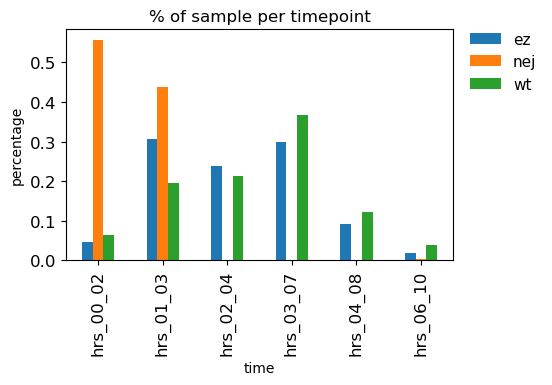

In [39]:
cellpercent = adata.obs[['sample','time']]
cellpercent = pd.crosstab(cellpercent['time'],cellpercent['sample'], normalize=False)
cellpercent = cellpercent.apply(lambda x: x/sum(x), axis=0)

cellpercent.plot(kind='bar', stacked=False, figsize=(5,3),title="% of sample per timepoint",
                 ylabel='percentage',fontsize=12).legend(ncol=1,  frameon=False, 
                                                  fontsize=11, bbox_to_anchor=(1.25, 1.05))

In [17]:
sorted(adata.obs['time'].unique())

adata.obs['time2']=adata.obs['time'].map({
    'hrs_00_02':'early (hrs 00-03)', 'hrs_01_03':'early (hrs 00-03)',
     'hrs_02_04':'mid (hrs 02-07)', 'hrs_03_07':'mid (hrs 02-07)',
     'hrs_04_08':'late (hrs 04-10)', 'hrs_06_10':'late (hrs 04-10)'} )


In [6]:
pd.DataFrame(adata.obs['time'].value_counts())

time
hrs_03_07  7019
hrs_01_03  5566
hrs_02_04  4476
hrs_00_02  2340
hrs_04_08  2273
hrs_06_10   684

(array([0, 1, 2]),
 [Text(0, 0, 'Wild-type'), Text(1, 0, 'E(z)-KD'), Text(2, 0, 'CBP-KD')])

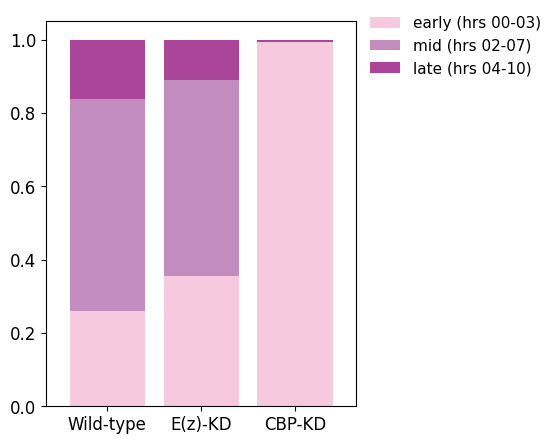

In [18]:
cellpercent = adata.obs[['sample','time2']]
cellpercent = pd.crosstab(cellpercent['sample'],cellpercent['time2'], normalize=False)
cellpercent = cellpercent.apply(lambda x: x/sum(x), axis=1)

cellpercent=cellpercent[['early (hrs 00-03)',
             'mid (hrs 02-07)', 
             'late (hrs 04-10)' ]].loc[[ 'wt','ez', 'nej']]
cellpercent.index=['Wild-type', 'E(z)-KD', 'CBP-KD']
cellpercent.plot(kind='bar', stacked=True, figsize=(4,5), width=0.8,
                color=['#f6c9df', '#c38cbe','#aa459a'],fontsize=12,
                title="").legend(ncol=1,  frameon=False, fontsize=11, bbox_to_anchor=(1., 1.05))
plt.xticks(rotation=0)

# palantir

In [102]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import phenograph

from scipy.sparse import csr_matrix, find, issparse
from scipy.sparse.linalg import eigs
import scanpy as sc

## to avoid libraries incompatibilities, only following functions have been used from palantir library

def run_diffusion_maps(data_df, n_components=10, knn=30, alpha=0, seed=None):
    """Run Diffusion maps using the adaptive anisotropic kernel
    :param data_df: PCA projections of the data or adjacency matrix
    :param n_components: Number of diffusion components
    :param knn: Number of nearest neighbors for graph construction
    :param alpha: Normalization parameter for the diffusion operator
    :param seed: Numpy random seed, randomized if None, set to an arbitrary integer for reproducibility
    :return: Diffusion components, corresponding eigen values and the diffusion operator
    """

    # Determine the kernel
    N = data_df.shape[0]
    if not issparse(data_df):
        print("Determing nearest neighbor graph...")
        temp = sc.AnnData(data_df.values)
        sc.pp.neighbors(temp, n_pcs=0, n_neighbors=knn)
        kNN = temp.obsp['distances']

        # Adaptive k
        adaptive_k = int(np.floor(knn / 3))
        adaptive_std = np.zeros(N)

        for i in np.arange(len(adaptive_std)):
            adaptive_std[i] = np.sort(kNN.data[kNN.indptr[i] : kNN.indptr[i + 1]])[
                adaptive_k - 1
            ]

        # Kernel
        x, y, dists = find(kNN)

        # X, y specific stds
        dists = dists / adaptive_std[x]
        W = csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])

        # Diffusion components
        kernel = W + W.T
    else:
        kernel = data_df

    # Markov
    D = np.ravel(kernel.sum(axis=1))

    if alpha > 0:
        # L_alpha
        D[D != 0] = D[D != 0] ** (-alpha)
        mat = csr_matrix((D, (range(N), range(N))), shape=[N, N])
        kernel = mat.dot(kernel).dot(mat)
        D = np.ravel(kernel.sum(axis=1))
    
    D[D != 0] = 1 / D[D != 0]
    T = csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)
    # Eigen value dcomposition
    np.random.seed(seed)
    v0 = np.random.rand(min(T.shape))
    D, V = eigs(T, n_components, tol=1e-4, maxiter=1000, v0=v0)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    # Create are results dictionary
    res = {"T": T, "EigenVectors": V, "EigenValues": D}
    res["EigenVectors"] = pd.DataFrame(res["EigenVectors"])
    if not issparse(data_df):
        res["EigenVectors"].index = data_df.index
    res["EigenValues"] = pd.Series(res["EigenValues"])
    res["kernel"] = kernel
    return res



def determine_multiscale_space(dm_res, n_eigs=None):
    """Determine multi scale space of the data
    :param dm_res: Diffusion map results from run_diffusion_maps
    :param n_eigs: Number of eigen vectors to use. If None specified, the number
            of eigen vectors will be determined using eigen gap
    :return: Multi scale data matrix
    """
    if n_eigs is None:
        vals = np.ravel(dm_res["EigenValues"])
        n_eigs = np.argsort(vals[: (len(vals) - 1)] - vals[1:])[-1] + 1
        if n_eigs < 3:
            n_eigs = np.argsort(vals[: (len(vals) - 1)] - vals[1:])[-2] + 1

    # Scale the data
    use_eigs = list(range(1, n_eigs))
    eig_vals = np.ravel(dm_res["EigenValues"][use_eigs])
    data = dm_res["EigenVectors"].values[:, use_eigs] * (eig_vals / (1 - eig_vals))
    data = pd.DataFrame(data, index=dm_res["EigenVectors"].index)

    return data

In [107]:
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)
dm_res = run_diffusion_maps(pca_projections, n_components=30, knn=30, alpha=0, seed=123)
ms_data = determine_multiscale_space(dm_res,n_eigs=4)
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_palantir")

# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos='X_pca2d')

Determing nearest neighbor graph...


/hpcnfs/home/ieo6625/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/home/ieo6625/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/home/ieo6625/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/home/ieo6625/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/home/ieo6625/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No d

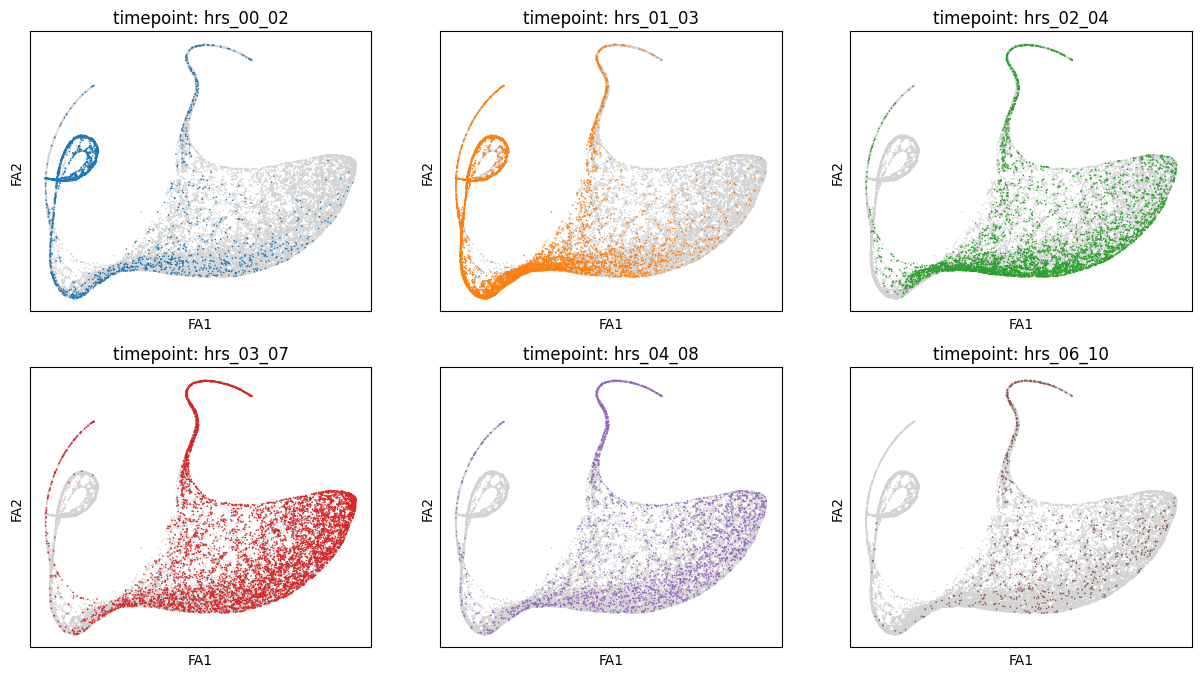

In [119]:
fig, axs=plt.subplots(2,3,figsize=(15,8))
axs=axs.ravel()
observ='time'
for i,s in enumerate(sorted(adata.obs[observ].unique())):
    sc.pl.draw_graph(adata, color=observ, groups=[s],legend_loc='top right',show=False,ax=axs[i], title='timepoint: %s'%(s))

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


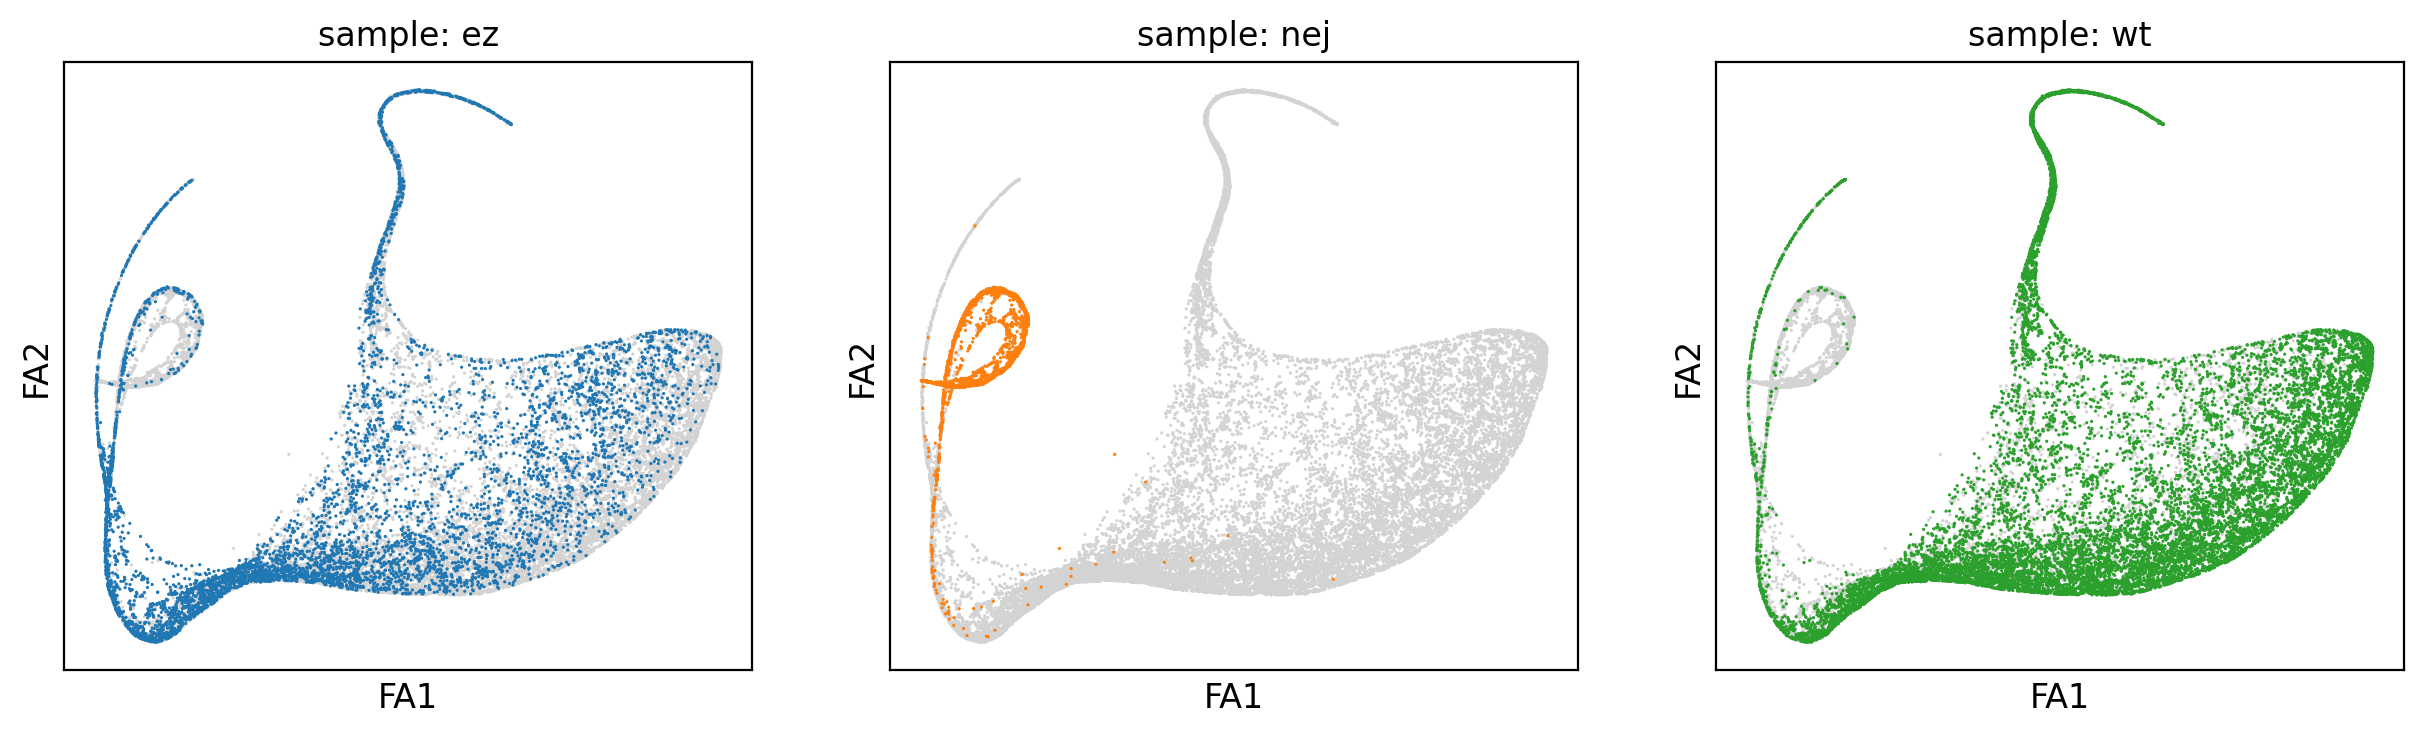

In [22]:
fig, axs=plt.subplots(1,3,figsize=(15,4))
axs=axs.ravel()
observ='sample'
for i,s in enumerate(sorted(adata.obs[observ].unique())):
    sc.pl.draw_graph(adata, color=observ, groups=[s],legend_loc='top right',show=False,ax=axs[i], title='sample: %s'%(s))

# scFates

In [2]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/" # to avoid crashes due to rpy2 not finding the R install on conda
import scFates as scf

In [59]:
scf.tl.tree(adata,
            Nodes=200 # n.of nodes composing the tree   #  range of 10 to 100 for ElPiGraph approach and 100 to 2000 for PPT approach.
            method='ppt',
            ppt_sigma=100,
            ppt_lambda=0.25,
            ppt_nsteps=200,
            use_rep='draw_graph_fa',
            ndims_rep=2,
            seed=123)

inferring a principal tree --> parameters used 
    15 principal points, sigma = 100, lambda = 0.25, metric = euclidean
    fitting:  51%|█████     | 102/200 [00:03<00:03, 30.99it/s]
    converged
    finished (0:00:03) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/simpleppt/ppt.py:267: RuntimeWarning: divide by zero encountered in log
  sigma / R.shape[0] * np.sum(R * np.log(R)),
/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/simpleppt/ppt.py:267: RuntimeWarning: invalid value encountered in multiply
  sigma / R.shape[0] * np.sum(R * np.log(R)),


In [61]:
scf.tl.root(adata, root=7) # root is manually selected based on its position in the embedding

node 7 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [62]:
scf.tl.convert_to_soft(adata,sigma=1000,lam=1, n_steps=200) 

Converting R into soft assignment matrix
    finished (0:00:01) --> updated 
    .obsm['X_R'] converted soft assignment of cells to principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


In [63]:
scf.tl.pseudotime(adata,
                #  n_jobs=1,
                  n_map=100, # number of probabilistic mapping of cells onto the tree to use
                  seed=123)

projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [34:11<00:00, 20.52s/it]
    finished (0:34:33) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


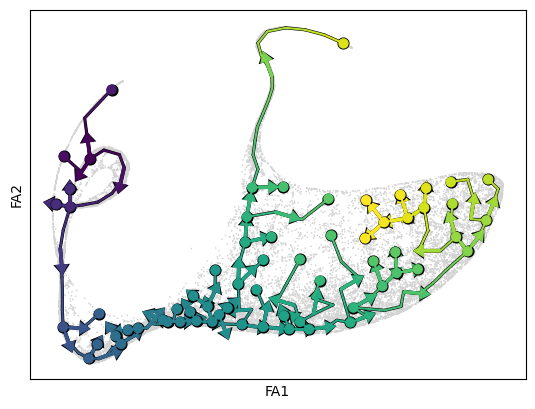

/hpcnfs/scratch/DIMA/piva/miniconda3/envs/scfates_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


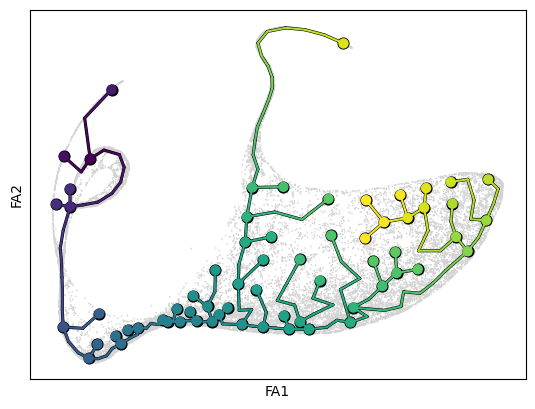

In [7]:
scf.pl.trajectory(adata,basis="draw_graph_fa",arrows=True,arrow_offset=3, scale_path=0.3)
scf.pl.trajectory(adata,basis="draw_graph_fa",arrows=False,scale_path=0.3)

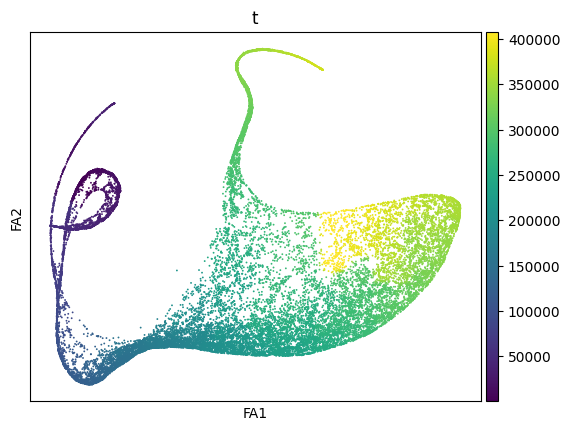

In [8]:
sc.pl.draw_graph(adata, color=['t'],ncols=4, wspace=0.25, size=7 ) #  legend_loc='on data'

In [17]:
sc.set_figure_params(dpi=100, figsize=(12, 6), fontsize=12)

In [18]:
colori_germs= {"anterioposterior_ectoderm": '#002554',
                "mesoderm":'#FA4616',
                "dorsal_ectoderm" :'#5E8AB4',
                "ventral_ectoderm": '#ab93c6',
                "anterior_endoderm":'#6CC24A',
                "posterior_endoderm": '#007041',
                "yolk" : '#efd129',
                "undifferentiated_cells" : '#b22987',
                "pluripotent_progenitors" :'#ff9900',
                "neuroectoderm":"#05C3DE"}

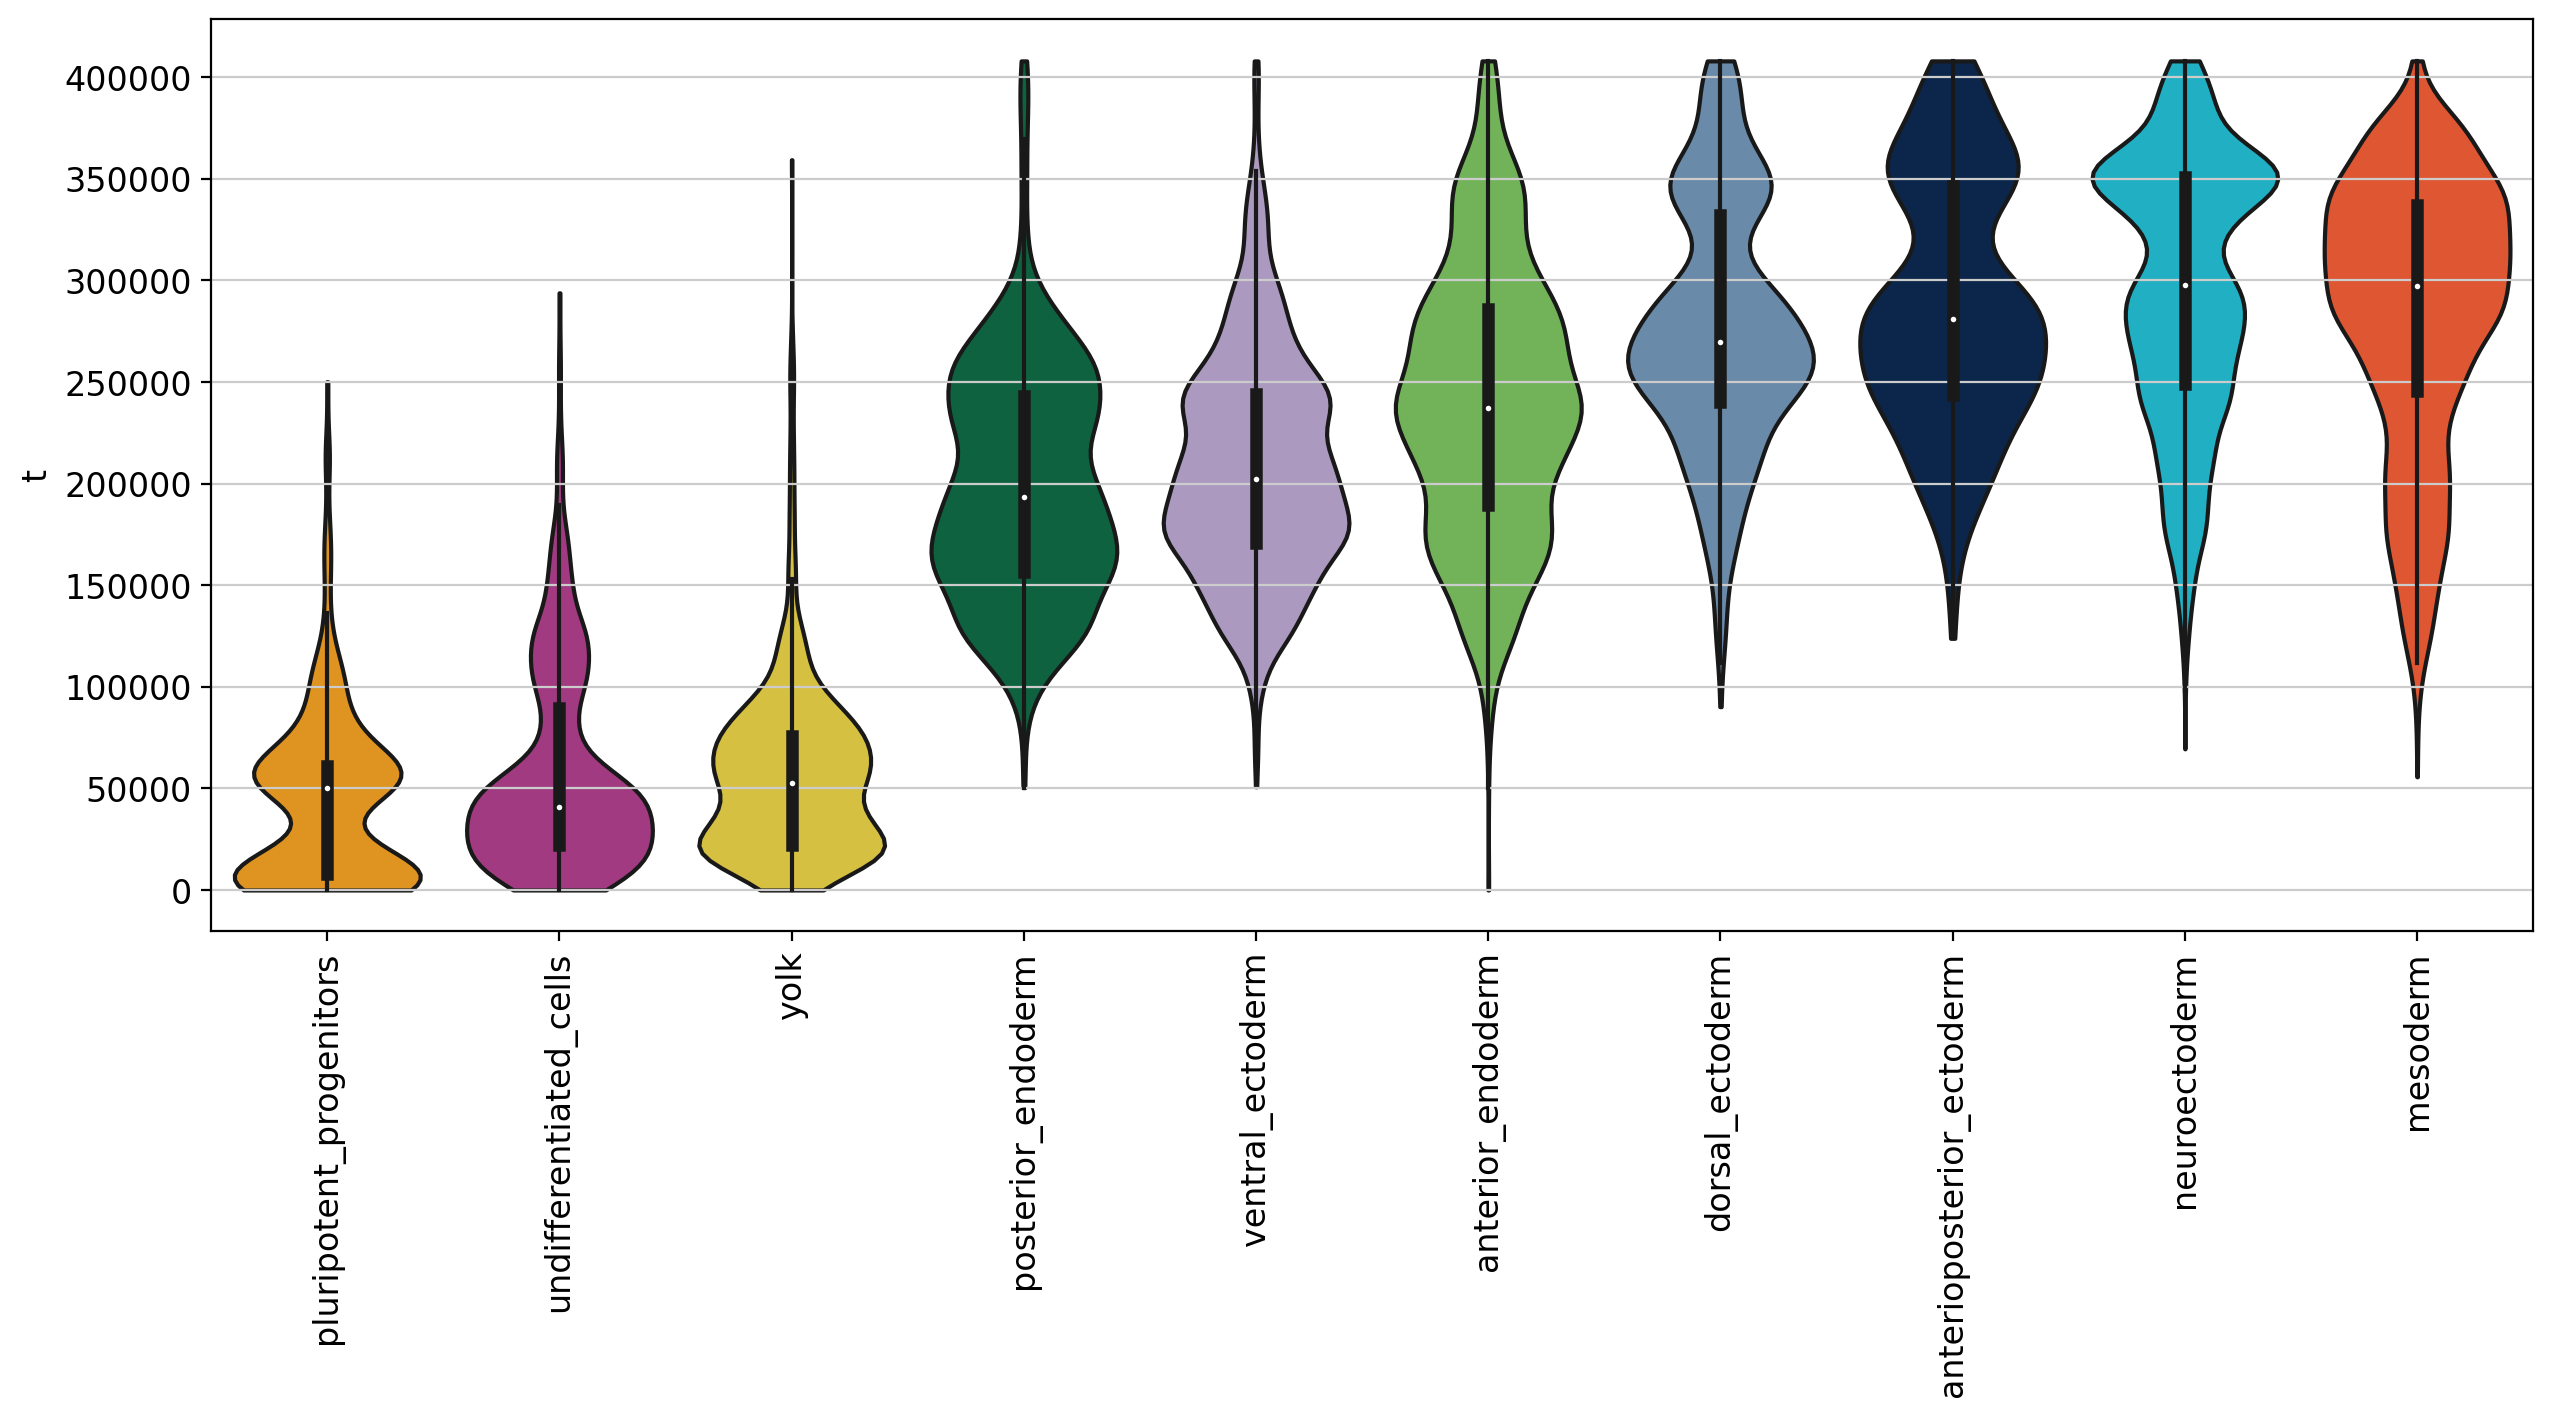

In [19]:
sc.pl.violin(adata,keys=['t'],groupby='annotation_leiden12', 
             palette=colori_germs,
             order=['pluripotent_progenitors','undifferentiated_cells','yolk', 'posterior_endoderm','ventral_ectoderm' ,'anterior_endoderm', 
             'dorsal_ectoderm','anterioposterior_ectoderm', 'neuroectoderm', 'mesoderm'],
             rotation=90, inner='box',stripplot=False,
            # save='_pseudotime_annotation2.pdf'
            )